### Module submission group
- Group member 1
    - Name: Kelsey Muckelbauer
    - Email: kam875@drexel.edu
- Group member 2
    - Name: Michael Fenton
    - Email: mpf24@drexel.edu
- Group member 3
    - Name: Will Wu
    - Email: ww437@drexel.edu
- Group member 4
    - Name: Ishtiaq Shahriar
    - Email: is353@drexel.edu

In [1]:
# SECTION 1 #
# Fetching data from API, writing to files

import requests
import json
from os.path import exists
import os

## CONFIGURABLES ##
loadGoogleColabEnv = True   # If using Google Colab, set to true
nbdir = "/content/drive/MyDrive/Colab Notebooks/Term Project/data/"   # Location of data files
first_page_number = 1       # First page to start querying for all three product variants
last_page_number = 10       # Last page to query, if max known page isn't reached first

if loadGoogleColabEnv:
  from google.colab import drive
  drive.mount('/content/drive')


# We have a limited number of requests.  Please only pull from API if/when needed.
# Please limit iterations when testing or confirming.
# Current API query count 1500/3500
rapidAPI_key = '4fdbce9a1amshfbcd3b7eec48546p15171djsn7a1ace54aa5e'


# ASIN = Amazon Standard Identification Number
# Max_fetch_page = last page of reviews that returns data
switch_versions = {
    'red_blue' : { 'asin' : 'B07VGRJDFY', 'max_fetch_page' : 325 }, #325 max
    'animal_crossing' : { 'asin' : 'B084DDDNRP', 'max_fetch_page' : 146 }, #146 max
    'gray' : { 'asin' : 'B07VJRZ62R', 'max_fetch_page' : 123 } #123 max
} 

response_list = []

for ver in switch_versions.keys():
    print('Starting API requests for: ' + ver)
    asin = switch_versions[ver]['asin']
    
    if exists(f'{nbdir}{asin}_FULL.json'):
        print(f'{asin}_FULL.json already exists.')
        continue
    
    for page_number in range(first_page_number, last_page_number + 1):           
        if page_number > switch_versions[ver]['max_fetch_page']:
            print(f'Max page fetched reached for {ver}.')
            break

        if (page_number % 5 == 0):
            print(f'Fetching page number: {page_number}')

        url = "https://amazon-product-reviews-keywords.p.rapidapi.com/product/reviews"
        querystring = {"asin":asin, "page": page_number, "country":"US","variants":"0","top":"1"}

        headers = {
            "X-RapidAPI-Host": "amazon-product-reviews-keywords.p.rapidapi.com",
            "X-RapidAPI-Key": rapidAPI_key
        }

        response = requests.request("GET", url, headers=headers, params=querystring)
        temp_dict = response.json()

        # If API returns errors, it will not have reviews
        if not 'reviews' in temp_dict.keys():
            print()
            print(f'Error retrieving page number: {page_number}')
            print(temp_dict)
            print('Continuing...')
            print()
            continue

        # If no reviews in response, we are at the end
        if len(temp_dict['reviews']) == 0 :  
            print(f'No more reviews for {ver}.')
            break

        response_list.extend(response.json()['reviews'])
        
    # Write a json file, with all fetched reviews, per version
    with open(f'{nbdir}{asin}_FULL.json', 'w', encoding='utf-8') as outfile:
        empty_dict = {}
        empty_dict['reviews'] = response_list
        json.dump(empty_dict, outfile, indent=2)

print(f'Finished.  {len(os.listdir(nbdir))} files in data directory.')

Mounted at /content/drive
Starting API requests for: red_blue
B07VGRJDFY_FULL.json already exists.
Starting API requests for: animal_crossing
B084DDDNRP_FULL.json already exists.
Starting API requests for: gray
B07VJRZ62R_FULL.json already exists.
Finished.  3 files in data directory.


In [2]:
# SECTION 2 #
# Parsing, tokenizing, and preparing data
# Creating word counts for further processing

from collections import Counter
from collections import defaultdict
# 100 most common English words. (source: Wikipedia)
# plus extra common words that held no meaning and showed up a lot in the reviews

common_words = ['the', 'be', 'to', 'of', 'and', 'a', 'in', 'that', 'have', 'i', 'it', 'for', 'not', 'on', 'with', 'he', 
                'as', 'you', 'do', 'at', 'this', 'but', 'his', 'by', 'from', 'they', 'we', 'say', 'her', 'she', 'or', 
                'an', 'will', 'my', 'one', 'all', 'would', 'there', 'their', 'what', 'so', 'up', 'out', 'if', 'about', 
                'who', 'get', 'which', 'go', 'me', 'when', 'make', 'can', 'like', 'time', 'no', 'just', 'him', 'know', 
                'take', 'people', 'into', 'year', 'your', 'good', 'some', 'could', 'them', 'see', 'other', 'than', 'then', 
                'now', 'look', 'only', 'come', 'its', 'over', 'think', 'also', 'back', 'after', 'use', 'two', 'how', 'our', 
                'work', 'first', 'well', 'way', 'even', 'new', 'want', 'because', 'any', 'these', 'give', 'day', 'most', 
                'us', 'is', 'was', 'the', 'are', "isn't", 'each', 'between', 'through', 'where', 'hadn', 'very', "you'll", 
                'while', "weren't", 'too', 'doesn', 'needn', 'has', 'd', 've', 'didn', 'further', 'why', 'mightn', 'haven', 
                'own', "mightn't", 'during', 'both', 'shan', "doesn't", 'theirs', 'herself', 'few', 'yourself', 'under', 
                "you've", 're', 'themselves', 'y', 'ma', 'above', 'such', "wouldn't", 'hers', 'nor', "shouldn't", 'hasn', 
                'myself', 'being', 'those', 'couldn', 'm', 'isn', 'aren', 'o', 'more', 'been', "needn't", 'had', 'll', 
                'against', 'once', "didn't", "shan't", "should've", "don't", 'below', 'yourselves', "wasn't", 'shouldn', 
                'does', "aren't", 'itself', 'same', 'should', 'before', 'am', "won't", 'having', "you'd", 'mustn', "that'll", 
                "couldn't", 'wasn', 'won', "hasn't", 'until', 'wouldn', "mustn't", 'ain', "you're", "she's", 't', 'off', 
                'yours', 'ourselves', 'himself', 'down', "haven't", 'ours', "hadn't", 's', "it's", 'weren', 'whom', 'again', 
                'here', 'did', 'doing', 'were', 'don']


# reduces redundancy
def make_dict() :
    return {
        'bad' : Counter(),
        'neutral' : Counter(),
        'good' : Counter()
    }
    
# reduces redundancy
#  receives each review chuck (rating, title, review, etc.)
def process_review(review, data_set):
        if review['rating'] == 3:
            rating = 'neutral'
            global total_neutral_count
            total_neutral_count += 1
        elif review['rating'] > 3:
            rating = 'good'
            global total_good_count
            total_good_count += 1
        else:
            rating = 'bad'
            global total_bad_count
            total_bad_count += 1 

        # for the review's title, parse and bucket
        # for the review's review, parse and bucket
        for review_type in ['review', 'title']:
            for word in review[review_type].split(' '):
                word = ''.join(filter(str.isalpha, word))  # remove nonalpha characters
                word = word.lower()
                if word:
                    if word not in common_words:
                        data_set[review_type][rating][word] += 1

#  Changed grouping to make training about 2/3 of entire set and test 1/3
training_data_set = {}
training_data_set['review'] = make_dict()
training_data_set['title'] = make_dict()
training_data_files = ["B07VGRJDFY_FULL.json", "B084DDDNRP_FULL.json"]  

test_data_set = {}
test_data_set['review'] = make_dict()
test_data_set['title'] = make_dict()
test_data_files = ["B07VJRZ62R_FULL.json"]

total_good_count= 0
total_bad_count = 0 
total_neutral_count = 0

for file in os.listdir(nbdir):
    data_set_type = ''
    with open(nbdir+file, 'r', encoding='utf-8') as inbound:
        j = json.load(inbound)
        if file in training_data_files:
            data_set_type = training_data_set      
            for review in j['reviews']:
                process_review(review, data_set_type)
        elif file in test_data_files:
            test_data_set = j

# Print results
print("TRAINING")
for data_section in training_data_set:
  print(data_section)
  for category in training_data_set[data_section]:
    print(f'{category} : {training_data_set[data_section][category].most_common}')

TRAINING
review
bad : <bound method Counter.most_common of Counter({'switch': 289, 'nintendo': 251, 'console': 133, 'game': 123, 'buy': 121, 'games': 116, 'price': 114, 'dont': 92, 'box': 85, 'play': 84, 'amazon': 80, 'product': 80, 'money': 80, 'bought': 74, 'system': 73, 'got': 69, 'im': 65, 'used': 59, 'wont': 54, 'cant': 53, 'charge': 52, 'controllers': 52, 'screen': 50, 'joy': 47, 'still': 47, 'gift': 46, 'never': 46, 'christmas': 46, 'return': 45, 'dock': 45, 'came': 45, 'controller': 45, 'doesnt': 44, 'son': 43, 'working': 42, 'months': 41, 'pay': 40, 'really': 38, 'received': 38, 'much': 38, 'nothing': 36, 'device': 36, 'great': 36, 'already': 36, 'old': 36, 'right': 36, 'works': 35, 'worth': 34, 'days': 34, 'send': 34, 'weeks': 34, 'item': 34, 'purchase': 33, 'disappointed': 33, 'ive': 33, 'tried': 33, 'tv': 33, 'buying': 32, 'didnt': 32, 'stopped': 32, 'con': 32, 'left': 31, 'going': 30, 'month': 30, 'purchased': 30, 'online': 30, 'animal': 29, 'years': 29, 'opened': 29, 'con

In [3]:
# SECTION 3 #
# Naive Bayes sentiment analysis for Multiclass

import re
import math

def sentiment_analyzer(input):
  words = [word for word in [re.sub(r'[^a-zA-Z0-9]', '', word) for word in [word.lower() for word in input.split(' ')]] if word not in common_words ]

  positive_prior = math.log((total_good_count)/(total_bad_count+total_good_count+total_neutral_count))
  negative_prior = math.log((total_bad_count)/(total_bad_count+total_good_count+total_neutral_count))
  neutral_prior = math.log((total_neutral_count)/(total_bad_count+total_good_count+total_neutral_count))

  total_number_of_unique_words = {}
  
  for category in training_data_set['review']:
    total_number_of_unique_words = {**total_number_of_unique_words, **training_data_set['review'][category]}

  for word in words:
    positive_prior+= math.log((training_data_set['review']['good'][word]+1)/(sum(training_data_set['review']['good'].values())+len(total_number_of_unique_words)))
    negative_prior+= math.log((training_data_set['review']['bad'][word]+1)/(sum(training_data_set['review']['bad'].values())+len(total_number_of_unique_words)))
    neutral_prior+= math.log((training_data_set['review']['neutral'][word]+1)/(sum(training_data_set['review']['neutral'].values())+len(total_number_of_unique_words)))

  return positive_prior, negative_prior, neutral_prior



In [8]:
#Multiclass Classification

positive = 0
negative = 0
neutral =  0

negative_classified_as_positive = 0
neutral_classified_as_positive = 0
positive_classified_as_negative = 0
neutral_classified_as_negative = 0
positive_classified_as_neutral = 0
negative_classified_as_neutral = 0

for review in test_data_set['reviews']:
    text = review['review']
    good_score, bad_score, mediocre_score = sentiment_analyzer(text)
    rating = review['rating']

    if good_score > bad_score and good_score > mediocre_score:
        if rating >= 4:
            positive += 1
        if rating <= 2:
            negative_classified_as_positive +=1
        else:
            neutral_classified_as_positive +=1
    if bad_score > good_score and bad_score > mediocre_score:
        if rating <= 2:
            negative += 1
        if rating >= 4:
            positive_classified_as_negative +=1
        else:
            neutral_classified_as_negative +=1
    if mediocre_score > good_score and mediocre_score > bad_score:
        if rating == 3:
            neutral += 1
        if rating >= 4:
            positive_classified_as_neutral +=1
        else:
            negative_classified_as_neutral += 1
    

true_positive = positive + neutral + negative
false_positive = negative_classified_as_positive + neutral_classified_as_positive + positive_classified_as_negative + neutral_classified_as_negative+ positive_classified_as_neutral+negative_classified_as_neutral
true_negative = negative + neutral_classified_as_negative + negative_classified_as_neutral + neutral + positive + neutral_classified_as_positive + positive_classified_as_neutral + neutral + positive + negative_classified_as_positive + positive_classified_as_negative + negative
false_negative = positive_classified_as_negative + positive_classified_as_neutral + negative_classified_as_positive + negative_classified_as_neutral + neutral_classified_as_negative + neutral_classified_as_positive
                  
precision = true_positive / (true_positive + false_positive)
print("Precision: " + str(precision))

recall = true_positive / (true_positive + false_negative)
print("Recall: " + str(recall))

fmeas = (2 * precision * recall) / (precision + recall)
print("F-measure: " + str(fmeas))

accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
print("Accuracy: " + str(accuracy))


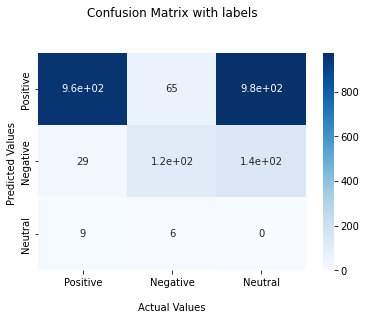

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

cf_matrix = np.array([[positive,negative_classified_as_positive,neutral_classified_as_positive],
                      [positive_classified_as_negative,negative,neutral_classified_as_negative],
                      [positive_classified_as_neutral,negative_classified_as_neutral,neutral]])

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel('Predicted Values ');

# Review labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive', 'Negative', 'Neutral'])
ax.yaxis.set_ticklabels(['Positive', 'Negative', 'Neutral'])

# Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
# Naive Bayes sentiment analysis for Binary class
# Classification without Neutral Reviews

import math
import sys

true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0

bad_word_count = sum(training_data_set['review']['bad'].values())
good_word_count = sum(training_data_set['review']['good'].values())

good_prior = total_good_count / (total_good_count + total_bad_count)
bad_prior = total_bad_count / (total_good_count + total_bad_count)

def classify(text):
    good_score = math.log(good_prior)
    bad_score = math.log(bad_prior)
    
    for word in text.split(' '):
        word = ''.join(filter(str.isalpha, word))  # remove nonalpha characters
        word = word.lower()
    
        if word in common_words:
            continue
    
        if word in training_data_set['review']['bad']:
            bad_score += math.log(training_data_set['review']['bad'][word] / bad_word_count)
            if word not in training_data_set['review']['good']:
                good_score += math.log(sys.float_info.epsilon)

        if word in training_data_set['review']['good']:
            good_score += math.log(training_data_set['review']['good'][word] / good_word_count)
            if word not in training_data_set['review']['bad']:
                bad_score += math.log(sys.float_info.epsilon)

    return good_score, bad_score
    
for review in test_data_set['reviews']:
    text = review['review']
    good_score, bad_score = classify(text)
    rating = review['rating']
    if rating == 3:
        continue
    if good_score > bad_score:
        if rating >= 4:
            true_positive += 1
        else:
            false_positive +=1
    else: 
        if rating >= 4:
            false_negative += 1
        else:
            true_negative +=1

precision = true_positive / (true_positive + false_positive)
print("Precision: " + str(precision))

recall = true_positive / (true_positive + false_negative)
print("Recall: " + str(recall))

fmeas = (2 * precision * recall) / (precision + recall)
print("F-measure: " + str(fmeas))

accuracy = (true_positive + true_negative) / (true_negative + true_positive + false_negative + false_positive)
print("Accuracy: " + str(accuracy))
           


Precision: 0.9024621212121212
Recall: 0.9587525150905433
F-measure: 0.9297560975609755
Accuracy: 0.8784810126582279


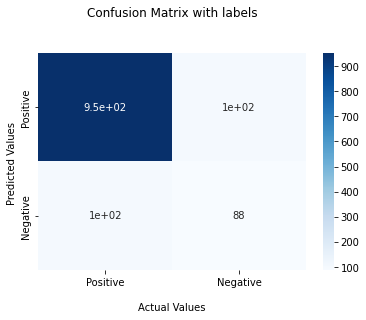

In [ ]:
cf_matrix = np.array([[true_positive,false_positive],
                      [false_positive,true_negative]])

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel('Predicted Values ');

# Review labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive', 'Negative'])
ax.yaxis.set_ticklabels(['Positive', 'Negative'])

# Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from pprint import pprint

red_blue_positive = 0
red_blue_negative = 0
red_blue_neutral = 0

animal_crossing_positive = 0
animal_crossing_negative = 0
animal_crossing_neutral = 0

gray_positive = 0
gray_negative = 0
gray_neutral = 0

for file in os.listdir(nbdir):
    data_set_type = ''
    with open(nbdir+file, 'r', encoding='utf-8') as inbound:
        j = json.load(inbound)
        if file in training_data_files:
            data_set_type = training_data_set      
            for review in j['reviews']:
              if review['asin']['original'] == 'B07VGRJDFY':
                if review['rating'] >= 4:
                  red_blue_positive += 1
                if review['rating'] <= 2:
                  red_blue_negative += 1
                else:
                  red_blue_neutral += 1
              if review['asin']['original'] == 'B084DDDNRP':
                if review['rating'] >= 4:
                  animal_crossing_positive += 1
                if review['rating'] <= 2:
                  animal_crossing_negative += 1
                else:
                  animal_crossing_neutral += 1
        elif file in test_data_files:
            for review in test_data_set['reviews']:
              if review['asin']['original'] == 'B07VJRZ62R':
                  if review['rating'] >= 4:
                    gray_positive += 1
                  if review['rating'] <= 2:
                    gray_negative += 1
                  else:
                    gray_neutral += 1
              


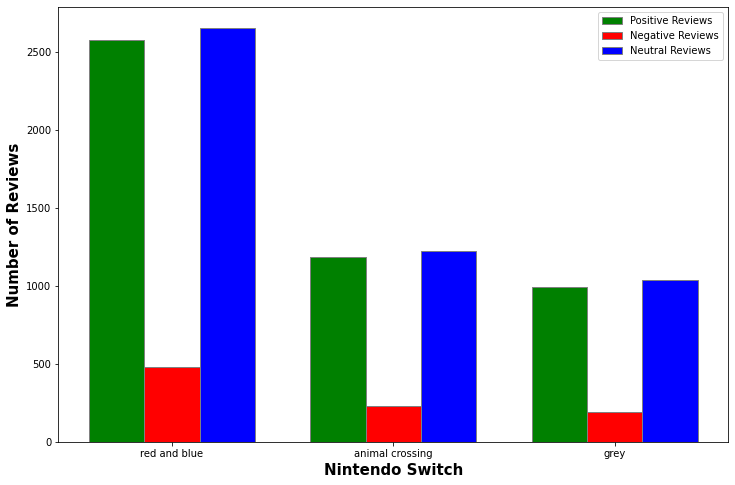

In [ ]:
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
positive_reviews = [red_blue_positive, animal_crossing_positive, gray_positive]
negative_reviews = [red_blue_negative, animal_crossing_negative, gray_negative]
neutral_reviews = [red_blue_neutral, animal_crossing_neutral, gray_neutral]

# Set position of bar on X axis
br1 = np.arange(len(positive_reviews))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, positive_reviews, color ='g', width = barWidth,
        edgecolor ='grey', label ='Positive Reviews')
plt.bar(br2, negative_reviews, color ='r', width = barWidth,
        edgecolor ='grey', label ='Negative Reviews')
plt.bar(br3, neutral_reviews, color ='b', width = barWidth,
        edgecolor ='grey', label ='Neutral Reviews')
 
# Adding Xticks
plt.xlabel('Nintendo Switch', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of Reviews', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(positive_reviews))],
        ['red and blue', 'animal crossing', 'grey'])
 
plt.legend()
plt.show()